In [1]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax

class WaveEquation2D(Problem):
    """Solves the time-dependent 1D viscous Burgers equation
        d^2 u       d^2 u    
        ----- - c^2 ----- = 0
        d t^2       d x^2    

        for (x, t) in [0, 1]^2

        Boundary conditions:
        u(0, t) = 0
        u(1, t) = 0
        u(x, 0) = sin(πx) + 0.5 sin(4πx)
        u_t(x, 0) = 0
    """

    @staticmethod
    def init_params(c=jnp.sqrt(2), sd=0.1):

        static_params = {
            "dims":(1,2),
            "c":c,
            "sd":sd,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh(x/sd) * tanh((1-x)/sd) * t**2 * u  + (sin(pi*x) + 0.5 * sin(4*pi*x))
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx
        return jnp.mean(phys**2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        c = all_params["static"]["problem"]["c"]
        x, t, sin, cos, pi = x_batch[:,0:1], x_batch[:,1:2], jnp.sin, jnp.cos, jnp.pi
        u = sin(pi*x)*cos(c*pi*t) + 0.5 * sin(4*pi*x)*cos(4*c*pi*t)
        return u

[INFO] 2025-03-28 01:16:18 - <fbpinns.constants.Constants object at 0x7fc2566f2490>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (0.0, 5.0)}
network: 

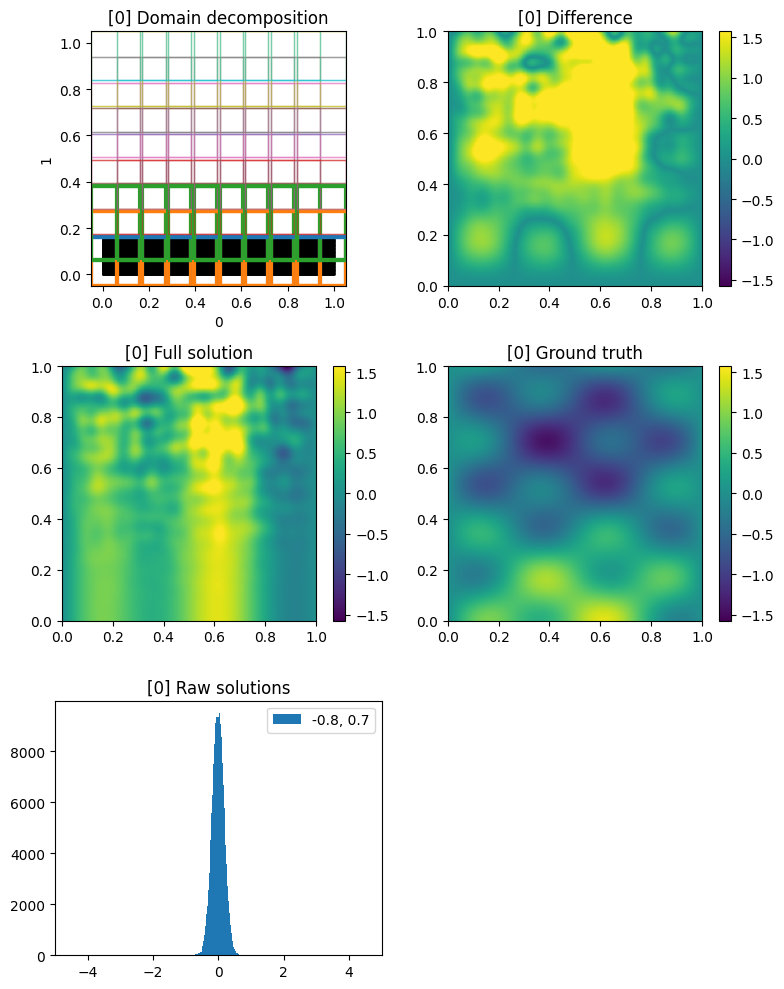

[INFO] 2025-03-28 01:16:30 - [i: 1000/100000] loss: 2562.9265 rate: 119.7 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:16:35 - [i: 2000/100000] loss: 726.3629 rate: 246.4 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:16:39 - [i: 3000/100000] loss: 180.1087 rate: 246.7 elapsed: 0.00 hr test
[INFO] 2025-03-28 01:16:43 - [i: 4000/100000] loss: 41.3855 rate: 246.5 elapsed: 0.01 hr test
[INFO] 2025-03-28 01:16:47 - [i: 5000/100000] loss: 13.0550 rate: 246.8 elapsed: 0.01 hr test
(40000, 2) (40000, 1) (40000, 1) (313600, 1) (313600, 1) (313600, 1) (26000, 2) (200, 200)
(1, 2) 2
True


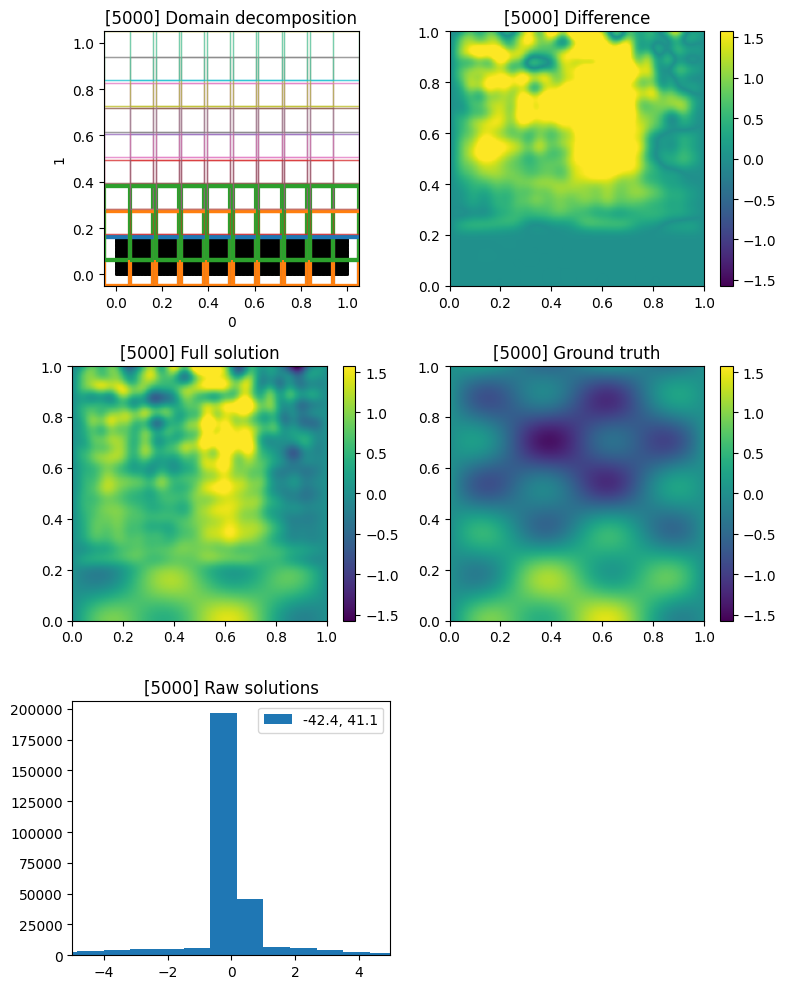

[INFO] 2025-03-28 01:16:49 - [i: 5264/100000] Updating active inputs..
[INFO] 2025-03-28 01:16:49 - [i: 5264/100000] Average number of points/dimension in active subdomains: 110.39
[INFO] 2025-03-28 01:16:51 - [i: 5264/100000] Updating active inputs done (2.15 s)
[INFO] 2025-03-28 01:16:51 - [i: 5264/100000] Compiling update step..
[INFO] 2025-03-28 01:16:51 - x_batch
[INFO] 2025-03-28 01:16:51 - (43600, 2), float32, JVPTracer
[INFO] 2025-03-28 01:16:51 - x_take
[INFO] 2025-03-28 01:16:51 - (333164, 2), float32, JVPTracer
[INFO] 2025-03-28 01:16:51 - x_batch
[INFO] 2025-03-28 01:16:51 - (43600, 2), float32, JVPTracer
[INFO] 2025-03-28 01:16:51 - x_take
[INFO] 2025-03-28 01:16:51 - (333164, 2), float32, JVPTracer
[INFO] 2025-03-28 01:16:53 - [i: 5264/100000] Compiling done (2.21 s)


KeyboardInterrupt: 

In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

subdomain_xs=[np.linspace(0,1,10), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,5.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 1),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=10
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((400,400),),
    n_test=(200,200),
    n_steps=100000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()